In [ ]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q

In [ ]:
import numpy as np
import pandas as ps
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

***Load Dataset***

In [ ]:
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: egishan
Your Kaggle Key: ··········


100%|██████████| 217M/217M [00:02<00:00, 96.0MB/s]


In [ ]:
BATCH_SIZE=32
IMAGE_SIZE=(128,128)

In [9]:
test_data_dir= "/content/cats-and-dogs-for-classification/cats_dogs/test"
train_data_dir="/content/cats-and-dogs-for-classification/cats_dogs/train"

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [11]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [12]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


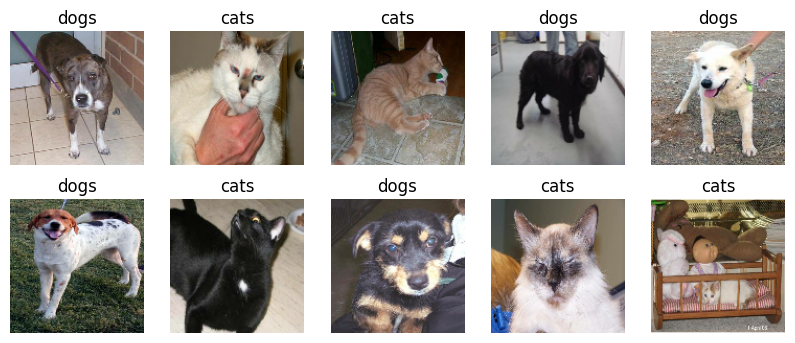

In [16]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

***Scaling Images***

In [17]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[ 67.26276     54.31848     30.125     ]
   [136.52423     97.78595     51.91797   ]
   [140.64319     98.62628     49.105408  ]
   ...
   [173.32812    150.32812    100.328125  ]
   [172.         149.          99.        ]
   [169.1474     146.1474      96.1474    ]]

  [[ 59.52887     48.26013     38.30078   ]
   [122.859375    88.10547     52.95703   ]
   [132.81232     95.76544     47.496033  ]
   ...
   [175.         152.         102.        ]
   [173.34222    150.34222    100.342224  ]
   [170.44922    147.44922     97.44922   ]]

  [[ 58.246094    50.44922     50.25647   ]
   [ 92.27344     67.347534    43.417908  ]
   [112.237976    80.44        40.5636    ]
   ...
   [176.         153.         103.        ]
   [174.         151.         101.        ]
   [169.64062    146.64062     96.640625  ]]

  ...

  [[192.86713    178.86713    129.86713   ]
   [183.17175    169.17175    120.17175   ]
   [186.20172    172.20172    123.20172   ]
   ...
   [124.58594    112.359

In [18]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

In [19]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[1.14889704e-02 1.14889704e-02 4.20592073e-03]
   [1.84177775e-02 1.74833406e-02 9.64020379e-03]
   [4.21597362e-02 2.67798323e-02 1.10935587e-02]
   ...
   [2.38627836e-01 2.76035935e-01 2.68943399e-01]
   [2.91349769e-01 3.46435547e-01 3.27762127e-01]
   [2.90462226e-01 3.56194466e-01 3.45425487e-01]]

  [[1.46905640e-02 1.86121315e-02 0.00000000e+00]
   [1.47518385e-02 1.38174016e-02 5.97426482e-03]
   [2.73131132e-02 1.19332112e-02 0.00000000e+00]
   ...
   [2.59330004e-01 2.96738088e-01 2.89645553e-01]
   [3.05237055e-01 3.60322833e-01 3.41649443e-01]
   [3.04327518e-01 3.70059729e-01 3.59290749e-01]]

  [[1.05822990e-02 1.45038683e-02 0.00000000e+00]
   [2.05422789e-02 1.96078438e-02 1.17647061e-02]
   [4.59108837e-02 3.05309817e-02 1.57781858e-02]
   ...
   [2.74145991e-01 3.11554074e-01 3.04461539e-01]
   [3.21561933e-01 3.76647711e-01 3.57974291e-01]
   [2.87284583e-01 3.53016824e-01 3.42247814e-01]]

  ...

  [[3.62736493e-01 4.72540408e-01 4.76461977e-01]
   [3

***Data Augmentation***

In [22]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

***Model Building***

In [23]:
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)      

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

***Model Training***

In [26]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=20,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/20
225/225 [==============================] - 19s 46ms/step - loss: 0.6771 - accuracy: 0.5869 - val_loss: 0.6915 - val_accuracy: 0.5225
Epoch 2/20
225/225 [==============================] - 10s 42ms/step - loss: 0.6301 - accuracy: 0.6378 - val_loss: 0.6909 - val_accuracy: 0.5813
Epoch 3/20
225/225 [==============================] - 10s 41ms/step - loss: 0.6280 - accuracy: 0.6371 - val_loss: 0.7041 - val_accuracy: 0.5200
Epoch 4/20
225/225 [==============================] - 9s 40ms/step - loss: 0.6124 - accuracy: 0.6568 - val_loss: 0.5903 - val_accuracy: 0.6837
Epoch 5/20
225/225 [==============================] - 9s 40ms/step - loss: 0.5982 - accuracy: 0.6789 - val_loss: 0.5908 - val_accuracy: 0.6450
Epoch 6/20
225/225 [==============================] - 9s 39ms/step - loss: 0.5801 - accuracy: 0.6890 - val_loss: 0.5449 - val_accuracy: 0.7337
Epoch 7/20
225/225 [==============================] - 10s 44ms/step - loss: 0.5726 - accuracy: 0.7000 - val_loss: 0.7741 - val_accuracy: 0.

In [27]:
history.history


{'loss': [0.6771314740180969,
  0.6301048398017883,
  0.6280015110969543,
  0.6124134659767151,
  0.5981924533843994,
  0.5800819993019104,
  0.5726080536842346,
  0.5606321096420288,
  0.5463864207267761,
  0.5339746475219727,
  0.5216561555862427,
  0.5056988596916199,
  0.49094489216804504,
  0.485556036233902,
  0.4833998382091522,
  0.4635065793991089,
  0.45508289337158203,
  0.4496944546699524,
  0.45370084047317505,
  0.4337814748287201],
 'accuracy': [0.5869444608688354,
  0.6377778053283691,
  0.6370833516120911,
  0.6568055748939514,
  0.6788889169692993,
  0.6890277862548828,
  0.699999988079071,
  0.7058333158493042,
  0.7247222065925598,
  0.7355555295944214,
  0.7404166460037231,
  0.7512500286102295,
  0.761388897895813,
  0.7668055295944214,
  0.7644444704055786,
  0.7761111259460449,
  0.7776389122009277,
  0.7859722375869751,
  0.7861111164093018,
  0.7952777743339539],
 'val_loss': [0.6915335655212402,
  0.6909172534942627,
  0.7040675282478333,
  0.5902837514877319

In [28]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 208.360 seconds


***Performance Analysis***

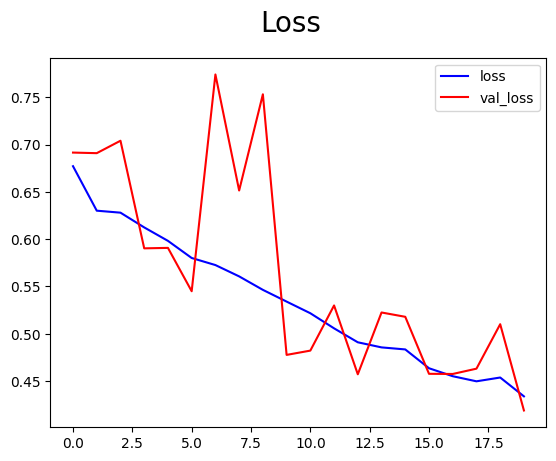

In [29]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

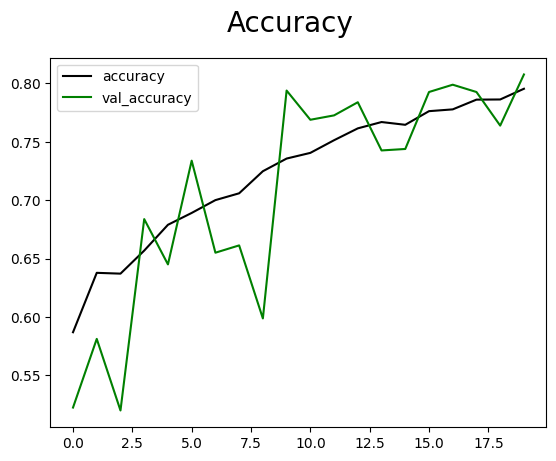

In [30]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='black', label='accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

***Model Evaluation***


In [31]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [32]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 364ms/step


In [33]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.82924336>

In [34]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.811>

In [35]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.822>

***Test***

In [36]:
!pip install opencv-python -q

In [37]:
import cv2

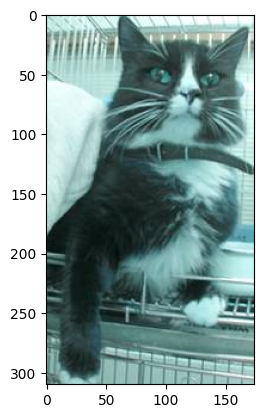

In [41]:
image = cv2.imread("/content/cats-and-dogs-for-classification/cats_dogs/test/cats/cat.4007.jpg")
plt.imshow(image)
plt.show()

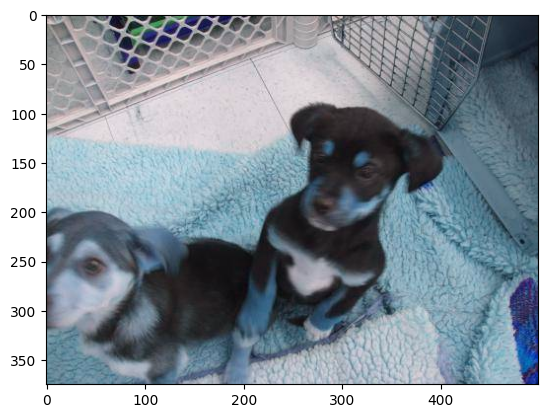

In [42]:
image = cv2.imread("/content/cats-and-dogs-for-classification/cats_dogs/test/dogs/dog.4018.jpg")
plt.imshow(image)
plt.show()

In [44]:
resized_image = tf.image.resize(image, IMAGE_SIZE)
scaled_image = resized_image/255

In [45]:
scaled_image

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.5571958 , 0.5142444 , 0.5220255 ],
        [0.49448878, 0.46840113, 0.48289257],
        [0.50653446, 0.5035101 , 0.52112657],
        ...,
        [0.12645526, 0.1617494 , 0.21665135],
        [0.11764706, 0.15294118, 0.20784314],
        [0.11764706, 0.1551011 , 0.19960171]],

       [[0.6172201 , 0.56273174, 0.5670669 ],
        [0.56096506, 0.5306861 , 0.537874  ],
        [0.6204977 , 0.6289941 , 0.6368481 ],
        ...,
        [0.1225337 , 0.15782782, 0.21272978],
        [0.11021753, 0.14551164, 0.2004136 ],
        [0.11021753, 0.14767157, 0.19217218]],

       [[0.74328613, 0.68270093, 0.68014276],
        [0.72618294, 0.689694  , 0.6910573 ],
        [0.6285771 , 0.6383504 , 0.642272  ],
        ...,
        [0.11861213, 0.15390626, 0.20880821],
        [0.10633204, 0.14162615, 0.19652812],
        [0.10588235, 0.1433364 , 0.187837  ]],

       ...,

       [[0.3601398 , 0.51445967, 0.5732832 ],
        [0.39

In [46]:
scaled_image.shape

TensorShape([128, 128, 3])

In [47]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [48]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 0s 222ms/step


In [49]:
yhat

array([[0.6973396]], dtype=float32)

In [50]:
class_names

['cats', 'dogs']

In [51]:
if yhat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')

dogs
